This is a very simple example how the path of a tornando can be identified using PAIRS leveraging its user-defined functions. On 10-20-2019 a major tornando went right through Dallas, TX (https://watchers.news/2019/10/25/ict-2019-dallas-tornadoes-the-costliest-tornado-event-in-texas-history-usa/)

In [1]:
from ibmpairs import paw
import matplotlib.pyplot as plt, pandas as pd, numpy as np, cv2, os

PAIRS_SERVER      = 'https://pairs.res.ibm.com'
PAIRS_USER        = '<username>'
PAIRS_CREDENTIALS = (
    PAIRS_USER, paw.get_pairs_api_password(PAIRS_SERVER, PAIRS_USER, passFile= os.path.expanduser('~/ibmpairspass.txt'))
)
data_id='49360'
lat0='32.84'
lat1='32.96'
lon0='-96.90'
lon1='-96.70'

query_json = {
    "layers": [
        {   
            "alias": "data_after",
            "id": data_id,
            "output": "false",
            "temporal" : {"intervals" : [{"snapshot" : "2019-10-22T00:00:00Z"}]}, 
            "type": "raster"
        },
        {
            "alias": "data_before",
            "id": data_id,
            "output": "false",
            "temporal" : {"intervals" : [{"snapshot" : "2019-10-07T00:00:00Z"}]}, 
            "type": "raster"
        },
        {
        "alias": "result_01_01",
        "expression": "$data_before-$data_after"
        }
    ],
    "name": "math_sample",
    "spatial" : {"type" : "square","coordinates" : [lat0,lon0,lat1,lon1]},  
    "temporal": {"intervals": [{"end": "2019-10-22T00:00:00Z", "start": "2019-10-22T00:00:00Z"}]}
}

query = paw.PAIRSQuery(query_json, PAIRS_SERVER, PAIRS_CREDENTIALS)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.


In [2]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string='Expression-result_01_01[result_01_01]-Exp'
extent = [
    query.metadata[id_string]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]
im_diff=query.data[id_string]

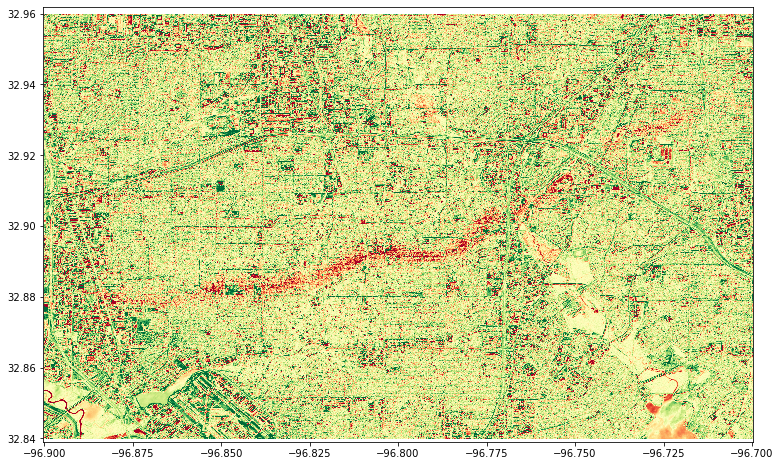

In [3]:
fig=plt.figure(figsize=(16,8))
plt.imshow(im_diff, extent = extent, cmap = 'RdYlGn', vmin=-0.05, vmax=0.05)
#fig.savefig('Tornado-path.png')

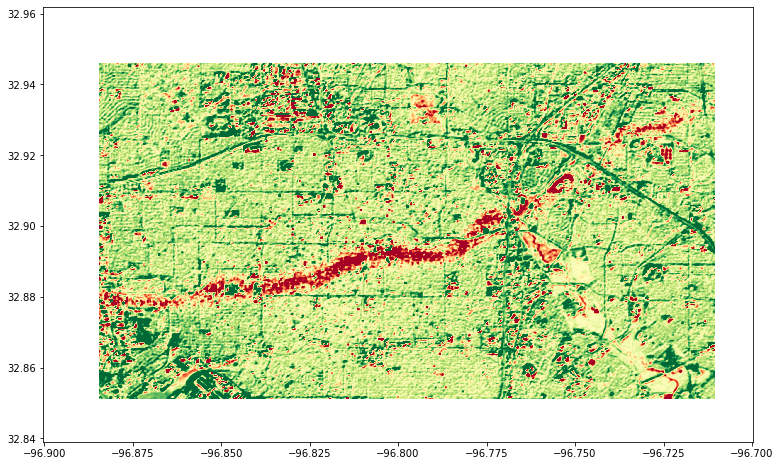

In [4]:
# filter the image for better visualization
n=10
kernel = np.ones((n,n),np.float32)/n/n
im_filtered = cv2.filter2D(im_diff,-1,kernel)
fig=plt.figure(figsize=(16,8))
plt.imshow(im_filtered, extent = extent, cmap = 'RdYlGn', vmin=-0.02, vmax=0.02)
fig.savefig('Tornado-path_filtered.png')